# V<sub>oc</sub> and V<sub>mp</sub> vs Irradiance and vs Temperature

This evaluation will use a PV module approximating a Rich Solar 200W 12V panel

In [33]:
# Setup
import pvlib
from pvlib.pvsystem import PVSystem, Array, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
# Get Module Parameters
# Get the module parameters from the CEC database
MODULE_24 = pvlib.pvsystem.retrieve_sam('CECMod')['JA_Solar_JAM5_L__72_200_SI']

# Create a dictionary of the parameters to represent the 12V Rich Solar module
# Scale the paremters that can be easily scaled
rich_solar_12V_params = {
    'Name' : 'Rich Solar 12V',
    'Technology': MODULE_24['Technology'],
    'Bifacial' : MODULE_24['Bifacial'],
    'STC' : MODULE_24['STC'],
    'PTC' : MODULE_24['PTC'],
    'A_c' : MODULE_24['A_c']*2,
    'Length' : MODULE_24['Length'],
    'Width' : MODULE_24['Width'],
    'N_s' : MODULE_24['N_s']/2,
    'I_sc_ref' : MODULE_24['I_sc_ref']*2,
    'V_oc_ref' : MODULE_24['V_oc_ref']/2,
    'I_mp_ref' : MODULE_24['I_mp_ref']*2,
    'V_mp_ref' : MODULE_24['V_mp_ref']/2,
    'alpha_sc' : MODULE_24['alpha_sc']*2,
    'beta_oc' : MODULE_24['beta_oc']/2,
    'gamma_r' : MODULE_24['gamma_r'],
    'T_NOCT' : MODULE_24['T_NOCT'],
    'irrad_ref' : 1000,
    'temp_ref' : 25
}

# Caculate the remaining parameters for the 12V module
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = pvlib.ivtools.sdm.fit_cec_sam(
                                                                         celltype='monoSi',
                                                                         v_mp=rich_solar_12V_params['V_mp_ref'],
                                                                         i_mp=rich_solar_12V_params['I_mp_ref'],
                                                                         v_oc=rich_solar_12V_params['V_oc_ref'],
                                                                         i_sc=rich_solar_12V_params['I_sc_ref'],
                                                                         alpha_sc=rich_solar_12V_params['alpha_sc'],
                                                                         beta_voc=rich_solar_12V_params['beta_oc'],
                                                                         gamma_pmp=rich_solar_12V_params['gamma_r'],
                                                                         cells_in_series=rich_solar_12V_params['N_s']
                                                                         )

# Add the calculated parameters to the dictionary representing the 12V Rich Solar module
rich_solar_12V_params['a_ref'] = a_ref
rich_solar_12V_params['I_L_ref'] = I_L_ref
rich_solar_12V_params['I_o_ref'] = I_o_ref
rich_solar_12V_params['R_s'] = R_s
rich_solar_12V_params['R_sh_ref'] = R_sh_ref
rich_solar_12V_params['Adjust'] = Adjust

# Addtional Parameters
EgRef = 1.121
dEgdT = -0.0002677

## V<sub>oc</sub> and V<sub>mp</sub> vs Irradiance

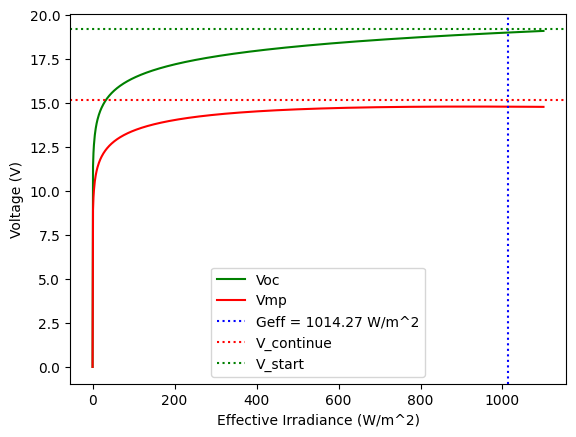

In [42]:
Temp = 68.78

Geff = np.linspace(0, 1100, 1000)

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    Geff,
    Temp,
    alpha_sc=rich_solar_12V_params['alpha_sc'],
    a_ref=rich_solar_12V_params['a_ref'],
    I_L_ref=rich_solar_12V_params['I_L_ref'],
    I_o_ref=rich_solar_12V_params['I_o_ref'],
    R_sh_ref=rich_solar_12V_params['R_sh_ref'],
    R_s=rich_solar_12V_params['R_s']
)

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}

curve_info = pvlib.pvsystem.singlediode(method='lambertw', **SDE_params)

plt.figure()
plt.plot(Geff,curve_info['v_oc'], label='Voc', color='g')
plt.plot(Geff,curve_info['v_mp'], label='Vmp', color='r')
#label the axes
plt.xlabel('Effective Irradiance (W/m^2)')
plt.ylabel('Voltage (V)')

#plot a vertical line at Geff = 1014.27 W/m^2
plt.axvline(x=1014.27, color='b', linestyle=':', label='Geff = 1014.27 W/m^2')

# plot a horizontal line at 15.2v for V_continue
plt.axhline(y=15.2, color='r', linestyle=':', label='V_continue')
# plot a horizontal line at 19.2v for V_start
plt.axhline(y=19.2, color='g', linestyle=':', label='V_start')
plt.legend()

## V<sub>oc</sub> and V<sub>mp</sub> vs Temperature

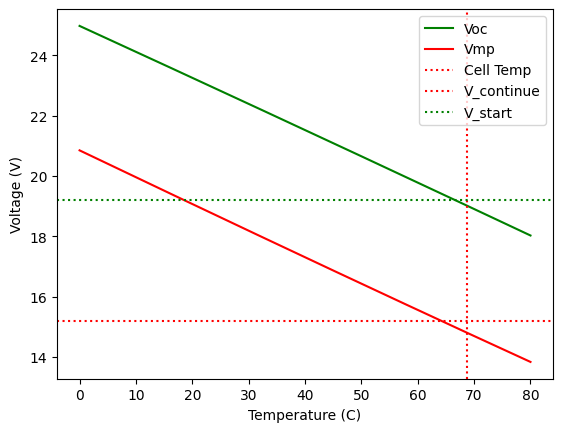

In [40]:
Temp = np.linspace(0, 80, 1000)

Geff = 1014.27

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    Geff,
    Temp,
    alpha_sc=rich_solar_12V_params['alpha_sc'],
    a_ref=rich_solar_12V_params['a_ref'],
    I_L_ref=rich_solar_12V_params['I_L_ref'],
    I_o_ref=rich_solar_12V_params['I_o_ref'],
    R_sh_ref=rich_solar_12V_params['R_sh_ref'],
    R_s=rich_solar_12V_params['R_s'],
    )

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}

curve_info = pvlib.pvsystem.singlediode(method='lambertw', **SDE_params)

plt.figure()
plt.plot(Temp,curve_info['v_oc'], label='Voc', color='g')
plt.plot(Temp,curve_info['v_mp'], label='Vmp', color='r')
#label the axes
plt.xlabel('Temperature (C)')
plt.ylabel('Voltage (V)')
#plt.ylim(0, 25)

#plot a vertical line at 68.78C for T_continue
plt.axvline(x=68.78, color='orange', linestyle=':', label='Cell Temp')

# plot a horizontal line at 15.2v for V_continue
plt.axhline(y=15.2, color='r', linestyle=':', label='V_continue')
# plot a horizontal line at 19.2v for V_start
plt.axhline(y=19.2, color='g', linestyle=':', label='V_start')
plt.legend()

TODO: Figure out why the voltage vs temperature performance here doesn't match the Phoenix data.

diode

photocurrent 11.898588406422846
saturation_current 3.68968675352568e-07
resistance_series 0.12270248066631148
resistance_shunt 194.4792269264424
nNsVth 1.1102641212801712
dc

i_sc 11.891084978201938
v_oc 19.18608360190865
i_mp 10.929954430794796
v_mp 14.968787599090424
p_mp 163.60816634230457
i_x 11.834078804806897
i_xx 7.679043506849262
cell temp
 66.78
Geff
 1014.27
panel

alpha_sc 0.006962
a_ref 0.973804158972974
I_L_ref 11.44031204496401
I_o_ref 7.608255760344541e-10
R_sh_ref 197.25444549468273
R_s 0.12270248066631148


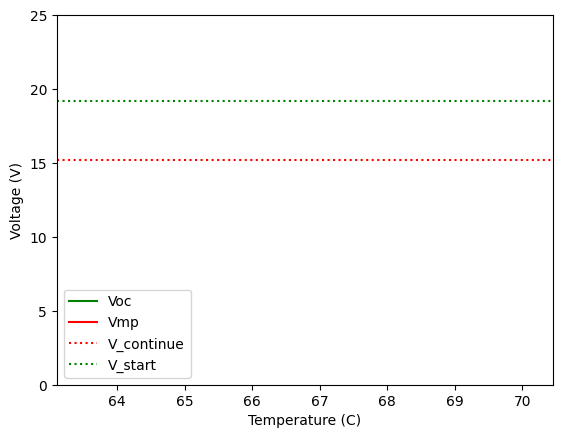

In [37]:
#run a particular case
#Temp = 25
Temp = 66.78

Geff = 1014.27

IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
    Geff,
    Temp,
    alpha_sc=rich_solar_12V_params['alpha_sc'],
    a_ref=rich_solar_12V_params['a_ref'],
    I_L_ref=rich_solar_12V_params['I_L_ref'],
    I_o_ref=rich_solar_12V_params['I_o_ref'],
    R_sh_ref=rich_solar_12V_params['R_sh_ref'],
    R_s=rich_solar_12V_params['R_s'],
    EgRef=EgRef,
    dEgdT=dEgdT
    )

# plug the parameters into the SDE and solve for IV curves:
SDE_params = {
    'photocurrent': IL,
    'saturation_current': I0,
    'resistance_series': Rs,
    'resistance_shunt': Rsh,
    'nNsVth': nNsVth
}

curve_info = pvlib.pvsystem.singlediode(method='lambertw', **SDE_params)

plt.figure()
plt.plot(Temp,curve_info['v_oc'], label='Voc', color='g')
plt.plot(Temp,curve_info['v_mp'], label='Vmp', color='r')
#label the axes
plt.xlabel('Temperature (C)')
plt.ylabel('Voltage (V)')
plt.ylim(0, 25)

# plot a horizontal line at 15.2v for V_continue
plt.axhline(y=15.2, color='r', linestyle=':', label='V_continue')
# plot a horizontal line at 19.2v for V_start
plt.axhline(y=19.2, color='g', linestyle=':', label='V_start')
plt.legend()

print('diode\n')
for key in SDE_params:
    print(key, SDE_params[key])

print('dc\n')
for key in curve_info:
    print(key, curve_info[key])

print('cell temp\n', Temp)
print('Geff\n', Geff)

print('panel\n')
print('alpha_sc', rich_solar_12V_params['alpha_sc'])
print('a_ref', rich_solar_12V_params['a_ref'])
print('I_L_ref', rich_solar_12V_params['I_L_ref'])
print('I_o_ref', rich_solar_12V_params['I_o_ref'])
print('R_sh_ref', rich_solar_12V_params['R_sh_ref'])
print('R_s', rich_solar_12V_params['R_s'])

